# Это ноутбук подготовленный для демонстрации этапов анализа данных на примера датасета Titanic.

Подключаем свой Google-Диск

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [2]:
import warnings
warnings.filterwarnings('ignore')

Устанавливаем недостающие библиотеки.

In [ ]:
!pip install pandas-profiling==2.7.1
!pip install missingpy

# В данной работе библиотеки подключаются по мере необходимости, чтобы была возможность сопоставить их название с кодом.

Подключаем Библиотеки для работы с набором данных.

In [4]:
import numpy as np
import pandas as pd

Загружаем набор данных.

In [6]:
path = "/content/gdrive/MyDrive/ML/Datasets/titanic/train.csv"   # Иногда могут быть проблемы с кирилицей в названиях папок на пути к файлу, постарайтесь всегда использовтаь только латиницу.
data = pd.read_csv(path, sep = ",")                               # Путь к файлу можно записать как отдельно, так и внутри метода read_csv.

В первую очередь стоит проверить корректность загрузки набора данных.

In [7]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


Теперь можно начать разведочный анализ данных: определить ключевые особенности данных и перечень проблем, требующих решения на этапе предварительной обработки.

In [9]:
data.shape      # Узнаём размер набора данных: количество строк - 891, количество столбцов 12

(891, 12)

В рассматриваемом наборе данных целевой переменной является столбец Survived, где 1 -> пассажир выжил, 0 -> пассажир погиб. Перед нами типичный представитель задачи бинарной классификации.
Определим сколько объектов каждого класса существет в нашем наборе данных.

In [10]:
data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [11]:
data.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Погибших больше чем выживших и причем на много. Даже не проводя статистических тестов можно сказать что выборка не сбалансированная. Необходимо это учесть при выборе метрики оценки качества классификации.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


При вызове метода info() можно узнать важную информацию про набор данных. Так информация представленная в 3-ем столбце под названием "Dtype", позволяет сделать следующие выводы: 
1.   5 категориальных признаков (object). 
2.   2 признака являются непрерывными (float64). 
3.   5 признаков принимают только целочисленные значения (int64).

In [12]:
X = data.drop(["Survived"], axis = 1)     # Резделим признаки и целевую переменную, это необходимо для удобства использования методов анализа данных.
y = data.Survived

# Так как перед нами стоит задача бинарной классификации необходимо уже в самом начале создать отложенную выборку для финальной проверки наших решений.

Для этого воспользуемся функцией train_test_split. Сделаем разделение с учетом дисбаланса классов: 80% - тренировочная выборка, 20% тестовая выборка. Не забываем сделать reset индексов строк для корректного использования перекрестной проверки на следующих этапах анализа.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y)

In [15]:
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [16]:
y_train.value_counts()

0    439
1    273
Name: Survived, dtype: int64

Мы будем имитировать процесс анализа данных таким образом, будто тестовая выборка нам не доступна, так что все функции предварительной обработки данных будет необходимо написать в виде пригодном для оперативного использования на новых данных.

In [17]:
X_train.drop(["PassengerId"], axis = 1).describe().T    # Сморим описательные статистики для набора данных

,count,mean,std,min,25%,50%,75%,max
Pclass,712.0,2.304775,0.845991,1.00,1.0000,3.0000,3.00000,3.0000
Age,568.0,29.636884,14.557095,0.67,20.0000,28.0000,38.00000,80.0000
SibSp,712.0,0.514045,1.106088,0.00,0.0000,0.0000,1.00000,8.0000
Parch,712.0,0.370787,0.775968,0.00,0.0000,0.0000,0.00000,6.0000
Fare,712.0,32.275900,49.315245,0.00,7.8958,14.4542,30.77185,512.3292


In [ ]:
X_train.shape

(712, 11)

In [18]:
X_train.isna().sum()  # Проверяем наличие пропущенных значений

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            144
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          543
Embarked         1
dtype: int64

In [ ]:
X_train.shape

(712, 11)

При желание для развернутого разведочного анализа можно воспользоватся функцией pandas_profiling.

In [19]:
import pandas_profiling

In [ ]:
#pandas_profiling.ProfileReport(X_train)

In [ ]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,328,2,"Ball, Mrs. (Ada E Hall)",female,36.0,0,0,28551,13.0000,D,S
1,622,1,"Kimball, Mr. Edwin Nelson Jr",male,42.0,1,0,11753,52.5542,D19,S
2,46,3,"Rogers, Mr. William John",male,NaN,0,0,S.C./A.4. 23567,8.0500,NaN,S
3,556,1,"Wright, Mr. George",male,62.0,0,0,113807,26.5500,NaN,S
4,319,1,"Wick, Miss. Mary Natalie",female,31.0,0,2,36928,164.8667,C7,S


In [ ]:
data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

В первую очередь обработаем признак под названием Name. На его основе создадим два новых признака: фималия и обращение (например, Miss., Mr. и т. д.). Для этого напишем короткую функцию, так как в дальнейшем нам придется повторить код для тестовой выборки, что поможет избежать дублирования.

In [23]:
import re  # Библиотека re позволяет использовать регулярные выражения.

In [24]:
def PreProcess_for_Name(data, col_Name):
  number_column_Name = data.columns.get_loc(col_Name)                        # Определяем индекс столбца с именами.
  
  Title_values = [re.sub("(.*, )|(\\..*)", "", x) for x in data[col_Name]]   # С помощью регулярных выражений формируем список типов обращений.
  data.insert(number_column_Name + 1, 'Title', Title_values)                 # Создаём новый столбец в данных, размещая его справа от столбца Name.

  return(data)

In [25]:
X_train = PreProcess_for_Name(X_train, "Name")

In [26]:
X_train.head()

,PassengerId,Pclass,Name,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,890,1,"Behr, Mr. Karl Howell",Mr,male,26.0,0,0,111369,30.0000,C148,C
1,810,1,"Chambers, Mrs. Norman Campbell (Bertha Griggs)",Mrs,female,33.0,1,0,113806,53.1000,E8,S
2,120,3,"Andersson, Miss. Ellis Anna Maria",Miss,female,2.0,4,2,347082,31.2750,NaN,S
3,607,3,"Karaic, Mr. Milan",Mr,male,30.0,0,0,349246,7.8958,NaN,S
4,516,1,"Walker, Mr. William Anderson",Mr,male,47.0,0,0,36967,34.0208,D46,S


Теперь столбец Name нам не нужен и мы его удаляем. Однако сделаем это в конце, а пока содадим список столбцов для удаления, чтобы сделать тоже самое для тестового набора данных.

In [27]:
list_for_drop = []

In [28]:
list_for_drop.append("Name")

In [29]:
X_train.head()

,PassengerId,Pclass,Name,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,890,1,"Behr, Mr. Karl Howell",Mr,male,26.0,0,0,111369,30.0000,C148,C
1,810,1,"Chambers, Mrs. Norman Campbell (Bertha Griggs)",Mrs,female,33.0,1,0,113806,53.1000,E8,S
2,120,3,"Andersson, Miss. Ellis Anna Maria",Miss,female,2.0,4,2,347082,31.2750,NaN,S
3,607,3,"Karaic, Mr. Milan",Mr,male,30.0,0,0,349246,7.8958,NaN,S
4,516,1,"Walker, Mr. William Anderson",Mr,male,47.0,0,0,36967,34.0208,D46,S


In [30]:
X_train.Title.value_counts() # Новый признак имет множество редких значений, объеденим их  в одну категорию.

Mr              412
Miss            151
Mrs              95
Master           33
Rev               5
Dr                4
Col               2
Major             2
Don               1
Jonkheer          1
Lady              1
Sir               1
the Countess      1
Mme               1
Ms                1
Mlle              1
Name: Title, dtype: int64

In [31]:
rare_title = X_train.Title.value_counts()[X_train.Title.value_counts() < 32].index  # Эта переменная нам ещё понадобиться, ведь редкие обращения могут быть и в тестовых данных.
X_train.Title = X_train.Title.replace(rare_title, 'Rare Title')

In [32]:
X_train.Title.value_counts()

Mr            412
Miss          151
Mrs            95
Master         33
Rare Title     21
Name: Title, dtype: int64

Обратим внимание на признаки SibSp и Parch. Они отображают количество родственников на борту. В связи с эти выражение SibSp + Parch + 1 = размеру семьи пассажира считая его самого.

In [ ]:
X_train.head()

,PassengerId,Pclass,Name,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,496,3,"Yousseff, Mr. Gerious",Mr,male,NaN,0,0,2627,14.4583,NaN,C
1,452,3,"Hagland, Mr. Ingvald Olai Olsen",Mr,male,NaN,1,0,65303,19.9667,NaN,S
2,713,1,"Taylor, Mr. Elmer Zebley",Mr,male,48.0,1,0,19996,52.0000,C126,S
3,489,3,"Somerton, Mr. Francis William",Mr,male,30.0,0,0,A.5. 18509,8.0500,NaN,S
4,695,1,"Weir, Col. John",Rare Title,male,60.0,0,0,113800,26.5500,NaN,S


In [33]:
def count_family(data, list_name_columns):
  number_column_Name = data.columns.get_loc(list_name_columns[1])

  size_family = data[list_name_columns[0]] + data[list_name_columns[1]] + 1
  data.insert(number_column_Name - 1, 'Fsize', size_family)

  size_family_discrete = ['large' if x > 4 else 'small' if (x < 5) & (x > 1) else 'singleton' for x in data.Fsize]
  data.insert(number_column_Name, 'FsizeDiscrete', size_family_discrete)

  return(data)

In [34]:
X_train = count_family(X_train, ["SibSp", "Parch"])

In [35]:
X_train["FsizeDiscrete"].value_counts()

singleton    437
small        226
large         49
Name: FsizeDiscrete, dtype: int64

In [36]:
X_train.head()

,PassengerId,Pclass,Name,Title,Sex,Age,Fsize,FsizeDiscrete,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,890,1,"Behr, Mr. Karl Howell",Mr,male,26.0,1,singleton,0,0,111369,30.0000,C148,C
1,810,1,"Chambers, Mrs. Norman Campbell (Bertha Griggs)",Mrs,female,33.0,2,small,1,0,113806,53.1000,E8,S
2,120,3,"Andersson, Miss. Ellis Anna Maria",Miss,female,2.0,7,large,4,2,347082,31.2750,NaN,S
3,607,3,"Karaic, Mr. Milan",Mr,male,30.0,1,singleton,0,0,349246,7.8958,NaN,S
4,516,1,"Walker, Mr. William Anderson",Mr,male,47.0,1,singleton,0,0,36967,34.0208,D46,S


Признаки PassengerId и Ticket нам бесполезны в виду большого числа уникальных значений и отсутствие возможности извлеч полезную информацию, если есть желающие можете сделать это самостоятельно, ка кэто было проделано мной с признаком Name.

In [37]:
list_for_drop.append("PassengerId")
list_for_drop.append("Ticket")

In [38]:
X_train.isna().sum()

PassengerId        0
Pclass             0
Name               0
Title              0
Sex                0
Age              144
Fsize              0
FsizeDiscrete      0
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            543
Embarked           1
dtype: int64

In [39]:
X_train.shape

(712, 14)

Хотя признак Cabin и содержит большое количество пропущенных значений и много уникальных кают, мы можем кое что сделать. Буква в название скорее всего означет блок или палубу где распологалась каюта. В связи с этим сделаем новый признак.

In [40]:
def select_deck(data, col_name):
  number_column_Name = data.columns.get_loc(col_name)

  data[col_name].fillna('', inplace = True)
  Deck_values = [x[0] if x != '' else 'X' for x in data.Cabin]

  data.insert(number_column_Name, 'Deck', Deck_values)
  data.Cabin = data.Cabin.replace('', np.nan)
  data.Deck = data.Deck.replace('', np.nan)

  return(data)

In [41]:
X_train = select_deck(X_train, "Cabin")

In [42]:
list_for_drop.append("Cabin")

In [43]:
X_train["Embarked"].value_counts()

S    510
C    133
Q     68
Name: Embarked, dtype: int64

In [44]:
X_train = X_train.drop(list_for_drop, axis = 1)

In [45]:
X_train.head()

,Pclass,Title,Sex,Age,Fsize,FsizeDiscrete,SibSp,Parch,Fare,Deck,Embarked
0,1,Mr,male,26.0,1,singleton,0,0,30.0000,C,C
1,1,Mrs,female,33.0,2,small,1,0,53.1000,E,S
2,3,Miss,female,2.0,7,large,4,2,31.2750,X,S
3,3,Mr,male,30.0,1,singleton,0,0,7.8958,X,S
4,1,Mr,male,47.0,1,singleton,0,0,34.0208,D,S


In [46]:
X_train.Deck.value_counts()

X    543
C     50
B     39
D     26
E     24
A     14
F     11
G      4
T      1
Name: Deck, dtype: int64

In [ ]:
X_train.shape

(712, 11)

In [47]:
X_train.isna().sum()

Pclass             0
Title              0
Sex                0
Age              144
Fsize              0
FsizeDiscrete      0
SibSp              0
Parch              0
Fare               0
Deck               0
Embarked           1
dtype: int64

In [48]:
X_train.isnull().mean().sort_values(ascending = False)

Age              0.202247
Embarked         0.001404
Deck             0.000000
Fare             0.000000
Parch            0.000000
SibSp            0.000000
FsizeDiscrete    0.000000
Fsize            0.000000
Sex              0.000000
Title            0.000000
Pclass           0.000000
dtype: float64

Настало время обработать пропущенные значения. У нас есть как категориальные, так и количественные признаки. В связи с этим идеальным решением будет использовать алгортим MissForest.

In [49]:
from missingpy import MissForest                 # Подключаем библиотеку содержащию MissForest
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
import copy

MissForest может обрабатывать категориальные признаки, однако необходимо закодировать их числами.

In [ ]:
X_train.dtypes

Pclass             int64
Title             object
Sex               object
Age              float64
Fsize              int64
FsizeDiscrete     object
SibSp              int64
Parch              int64
Fare             float64
Deck              object
Embarked          object
dtype: object

In [50]:
def imputation_missing_value(data):
  categorical_feature_list = list(data.select_dtypes(include = 'object').columns)
  int_label = list(data.select_dtypes(include = 'object').columns) + list(data.select_dtypes(include = 'int64').columns)
  encoding_dict = defaultdict(LabelEncoder)

  original = copy.deepcopy(data)
  mask = original.isnull()

  for i in categorical_feature_list:
    data[i][pd.isnull(data[i])] = 'XXX'

  for col in categorical_feature_list:
    le = LabelEncoder()
    le.fit(list(data[col]))
    encoding_dict[col] = le

  for col in categorical_feature_list:
    data[col] = encoding_dict[col].transform(data[col])

  data = data.where(~mask, original)

  imputer = MissForest()
  cat_vars = [data.columns.get_loc(c) for c in categorical_feature_list if c in data]
  data_imputed = imputer.fit_transform(data, cat_vars)
  data_imputed = pd.DataFrame(data_imputed, columns = data.columns)

  for i in int_label:
    data_imputed[i] = data_imputed[i].astype(int)

  for col in categorical_feature_list:
    data_imputed[col] = encoding_dict[col].inverse_transform(data_imputed[col])

  return(data_imputed)

In [51]:
X_train.head()

,Pclass,Title,Sex,Age,Fsize,FsizeDiscrete,SibSp,Parch,Fare,Deck,Embarked
0,1,Mr,male,26.0,1,singleton,0,0,30.0000,C,C
1,1,Mrs,female,33.0,2,small,1,0,53.1000,E,S
2,3,Miss,female,2.0,7,large,4,2,31.2750,X,S
3,3,Mr,male,30.0,1,singleton,0,0,7.8958,X,S
4,1,Mr,male,47.0,1,singleton,0,0,34.0208,D,S


In [52]:
X_train = imputation_missing_value(X_train)

Iteration: 0
Iteration: 1
Iteration: 2


In [53]:
X_train.isna().sum()

Pclass           0
Title            0
Sex              0
Age              0
Fsize            0
FsizeDiscrete    0
SibSp            0
Parch            0
Fare             0
Deck             0
Embarked         0
dtype: int64

In [54]:
X_train.Embarked.value_counts()

S    510
C    134
Q     68
Name: Embarked, dtype: int64

Простое восстановление (Данный код не используется)

In [ ]:
#X_train.Age[X_train.Age.isnull() == True] = np.nanmedian(data.Age)
#X_train.Embarked[X_train.Embarked.isnull() == True] = "S"

In [55]:
X_train

,Pclass,Title,Sex,Age,Fsize,FsizeDiscrete,SibSp,Parch,Fare,Deck,Embarked
0,1,Mr,male,26.0,1,singleton,0,0,30.0000,C,C
1,1,Mrs,female,33.0,2,small,1,0,53.1000,E,S
2,3,Miss,female,2.0,7,large,4,2,31.2750,X,S
3,3,Mr,male,30.0,1,singleton,0,0,7.8958,X,S
4,1,Mr,male,47.0,1,singleton,0,0,34.0208,D,S
...,...,...,...,...,...,...,...,...,...,...,...
707,2,Mr,male,34.0,2,small,1,0,21.0000,X,S
708,2,Mr,male,36.0,1,singleton,0,0,10.5000,X,S
709,3,Mr,male,34.5,1,singleton,0,0,6.4375,X,C
710,3,Mr,male,21.0,1,singleton,0,0,7.9250,X,S


Кодируем категориальные переменные

In [56]:
X_train.Sex[X_train.Sex == "male"] = 0
X_train.Sex[X_train.Sex == "female"] = 1
X_train.Sex = X_train.Sex.astype(int)

X_train.FsizeDiscrete[X_train.FsizeDiscrete == "singleton"] = 0
X_train.FsizeDiscrete[X_train.FsizeDiscrete == "small"] = 1
X_train.FsizeDiscrete[X_train.FsizeDiscrete == "large"] = 2
X_train.FsizeDiscrete = X_train.FsizeDiscrete.astype(int)

In [57]:
X_train

,Pclass,Title,Sex,Age,Fsize,FsizeDiscrete,SibSp,Parch,Fare,Deck,Embarked
0,1,Mr,0,26.0,1,0,0,0,30.0000,C,C
1,1,Mrs,1,33.0,2,1,1,0,53.1000,E,S
2,3,Miss,1,2.0,7,2,4,2,31.2750,X,S
3,3,Mr,0,30.0,1,0,0,0,7.8958,X,S
4,1,Mr,0,47.0,1,0,0,0,34.0208,D,S
...,...,...,...,...,...,...,...,...,...,...,...
707,2,Mr,0,34.0,2,1,1,0,21.0000,X,S
708,2,Mr,0,36.0,1,0,0,0,10.5000,X,S
709,3,Mr,0,34.5,1,0,0,0,6.4375,X,C
710,3,Mr,0,21.0,1,0,0,0,7.9250,X,S


In [58]:
from sklearn.preprocessing import OneHotEncoder

In [59]:
X_train.dtypes

Pclass             int64
Title             object
Sex                int64
Age              float64
Fsize              int64
FsizeDiscrete      int64
SibSp              int64
Parch              int64
Fare             float64
Deck              object
Embarked          object
dtype: object

In [60]:
enc = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
quantitative_label = list(X_train.select_dtypes(include = 'int64').columns) + list(X_train.select_dtypes(include = 'float64').columns)

X_enc = X_train.drop(quantitative_label, axis = 1)
X_enc.head()

,Title,Deck,Embarked
0,Mr,C,C
1,Mrs,E,S
2,Miss,X,S
3,Mr,X,S
4,Mr,D,S


In [61]:
X_enc = enc.fit_transform(X_enc)
X_enc = pd.DataFrame(X_enc, columns = enc.get_feature_names())

In [62]:
X_enc.head()

,x0_Master,x0_Miss,x0_Mr,x0_Mrs,x0_Rare Title,x1_A,x1_B,x1_C,x1_D,x1_E,x1_F,x1_G,x1_T,x1_X,x2_C,x2_Q,x2_S
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [63]:
X_enc.shape

(712, 17)

In [64]:
X_train = pd.concat([X_train[quantitative_label], X_enc], axis = 1)

In [65]:
X_train.head()

,Pclass,Sex,Fsize,FsizeDiscrete,SibSp,Parch,Age,Fare,x0_Master,x0_Miss,x0_Mr,x0_Mrs,x0_Rare Title,x1_A,x1_B,x1_C,x1_D,x1_E,x1_F,x1_G,x1_T,x1_X,x2_C,x2_Q,x2_S
0,1,0,1,0,0,0,26.0,30.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,1,2,1,1,0,33.0,53.1000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,1,7,2,4,2,2.0,31.2750,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,3,0,1,0,0,0,30.0,7.8958,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,0,1,0,0,0,47.0,34.0208,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [66]:
X_train.shape

(712, 25)

Мы создали очень много признаков и большая их часть будет лишь создавать проблемы для наших моделей. Воспользуемся методами отбора информативных и сократим признаковое пространство.

In [67]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

In [68]:
model = RandomForestClassifier(n_estimators = 100, criterion = "entropy")

In [70]:
%%time

res_f1 = []
for i in range(2, 25, 1):
  select_k_best_classifier = SelectKBest(mutual_info_classif, k = i)
  X_new = select_k_best_classifier.fit_transform(X_train, y_train)
  X_new = pd.DataFrame(X_new)

  skf = KFold(n_splits = 5)
  f1 = []
  for train_index, test_index in skf.split(y_train):
    X_t = X_new.iloc[train_index]
    X_v = X_new.iloc[test_index]
    y_t = y_train[train_index]
    y_v = y_train[test_index]

    model.fit(X_t, y_t)
    preds = model.predict(X_t)
    f1.append(f1_score(y_t, preds))

  res_f1.append(np.mean(f1))

CPU times: user 25.7 s, sys: 49.6 ms, total: 25.7 s
Wall time: 25.8 s


In [71]:
feature_f1 = pd.DataFrame({'count_feature': list(range(2, 25, 1)), 'f1': res_f1})

In [72]:
feature_f1

,count_feature,f1
0,2,0.872037
1,3,0.884364
2,4,0.884230
3,5,0.901913
4,6,0.888793
5,7,0.984259
6,8,0.986978
7,9,0.905055
8,10,0.986977
9,11,0.987010


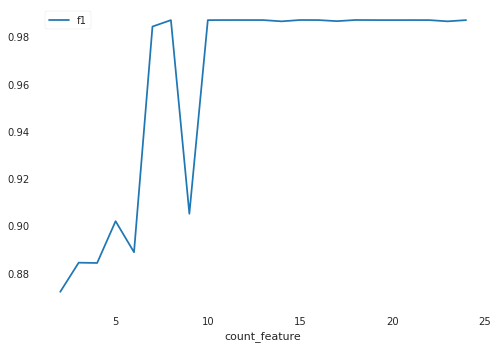

In [73]:
feature_f1.plot.line("count_feature", "f1")

In [ ]:
X_train

,Pclass,Sex,Fsize,FsizeDiscrete,SibSp,Parch,Age,Fare,x0_Master,x0_Miss,x0_Mr,x0_Mrs,x0_Rare Title,x1_A,x1_B,x1_C,x1_D,x1_E,x1_F,x1_G,x1_T,x1_X,x2_C,x2_Q,x2_S
0,3,0,1,0,0,0,27.247143,14.4583,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,3,0,2,1,1,0,24.167333,19.9667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1,0,2,1,1,0,48.000000,52.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,0,1,0,0,0,30.000000,8.0500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,0,1,0,0,0,60.000000,26.5500,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,3,0,1,0,0,0,45.500000,7.2250,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
708,3,1,1,0,0,0,17.369123,7.7333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
709,3,0,1,0,0,0,28.390427,7.3125,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
710,3,1,1,0,0,0,19.814694,7.8792,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [74]:
select_k_best_classifier = SelectKBest(mutual_info_classif, k = 10)
feature_names = list(X_train.columns.values)

X_train = select_k_best_classifier.fit_transform(X_train, y_train)

In [75]:
mask = select_k_best_classifier.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

In [76]:
X_train = pd.DataFrame(X_train, columns = new_features)

In [77]:
X_train

,Pclass,Sex,FsizeDiscrete,Age,Fare,x0_Miss,x0_Mr,x0_Mrs,x1_B,x1_X
0,1.0,0.0,0.0,26.0,30.0000,0.0,1.0,0.0,0.0,0.0
1,1.0,1.0,1.0,33.0,53.1000,0.0,0.0,1.0,0.0,0.0
2,3.0,1.0,2.0,2.0,31.2750,1.0,0.0,0.0,0.0,1.0
3,3.0,0.0,0.0,30.0,7.8958,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,47.0,34.0208,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
707,2.0,0.0,1.0,34.0,21.0000,0.0,1.0,0.0,0.0,1.0
708,2.0,0.0,0.0,36.0,10.5000,0.0,1.0,0.0,0.0,1.0
709,3.0,0.0,0.0,34.5,6.4375,0.0,1.0,0.0,0.0,1.0
710,3.0,0.0,0.0,21.0,7.9250,0.0,1.0,0.0,0.0,1.0


Удаление дубликатов

Теперь мы готовы непосредственно приступить к обучению моделей и настройки их гиперпараметров.

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
model_RF = RandomForestClassifier(n_jobs = -1, n_estimators = 100)
parameters_RF = {'criterion':('entropy', 'gini'), 'max_depth':[3, 4, 5, 6, 7]}

model_KNN = KNeighborsClassifier(n_jobs = -1)
parameters_KNN = {'weights':('uniform', 'distance'), 'n_neighbors':[3, 4, 5, 6, 7], 'algorithm':["auto", "ball_tree", "kd_tree", "brute"], "p":[1, 2, 3, 4, 5]}

model_GB = GradientBoostingClassifier(n_estimators = 100)
parameters_GB = {'loss':('deviance', 'exponential'), 'max_depth':[3, 4, 5, 6, 7]}

model_SVC = SVC()
parameters_SVC = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[.3, .4, .5, .6, .7, 1, 1.5]}

In [ ]:
%%time
clf = GridSearchCV(estimator = model_RF, param_grid = parameters_RF, cv = 5, scoring = "f1")
clf.fit(X_train, y_train)

CPU times: user 7.88 s, sys: 559 ms, total: 8.44 s
Wall time: 17 s


In [ ]:
print(clf.best_params_)
print(clf.best_score_)

{'criterion': 'entropy', 'max_depth': 4}
0.7632808606790181


In [ ]:
model_RF = RandomForestClassifier(n_jobs = -1, n_estimators = 100, criterion = "entropy", max_depth = 4)

In [ ]:
%%time
clf = GridSearchCV(estimator = model_KNN, param_grid = parameters_KNN, cv = 5, scoring = "f1")
clf.fit(X_train, y_train)

CPU times: user 23.9 s, sys: 5.34 s, total: 29.3 s
Wall time: 42.1 s


In [ ]:
print(clf.best_params_)
print(clf.best_score_)

{'algorithm': 'auto', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
0.6781359026800964


In [ ]:
model_KNN = KNeighborsClassifier(n_jobs = -1, algorithm = 'auto', weights = "distance", n_neighbors = 7, p = 1)

In [ ]:
%%time
clf = GridSearchCV(estimator = model_GB, param_grid = parameters_GB, cv = 5, scoring = "f1")
clf.fit(X_train, y_train)

CPU times: user 10.7 s, sys: 4.66 ms, total: 10.7 s
Wall time: 10.7 s


In [ ]:
print(clf.best_params_)
print(clf.best_score_)

{'loss': 'deviance', 'max_depth': 4}
0.747015691767125


In [ ]:
model_GB = GradientBoostingClassifier(n_estimators = 100, loss = 'deviance', max_depth = 4)

In [ ]:
%%time
clf = GridSearchCV(estimator = model_SVC, param_grid = parameters_SVC, cv = 5, scoring = "f1")
clf.fit(X_train, y_train)

CPU times: user 18.5 s, sys: 500 µs, total: 18.5 s
Wall time: 18.5 s


In [ ]:
print(clf.best_params_)
print(clf.best_score_)

{'C': 1, 'kernel': 'linear'}
0.7292008739845299


In [ ]:
model_SVC = SVC(C = 1, kernel = 'linear')

In [ ]:
X_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,844,3,"Lemberopolous, Mr. Peter L",male,34.5,0,0,2683,6.4375,NaN,C
1,292,1,"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1,0,11967,91.0792,B49,C
2,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0000,B28,NaN
3,16,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
4,766,1,"Hogeboom, Mrs. John C (Anna Andrews)",female,51.0,1,0,13502,77.9583,D11,S
...,...,...,...,...,...,...,...,...,...,...,...
174,789,3,"Dean, Master. Bertram Vere",male,1.0,1,2,C.A. 2315,20.5750,NaN,S
175,187,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,NaN,1,0,370365,15.5000,NaN,Q
176,335,1,"Frauenthal, Mrs. Henry William (Clara Heinshei...",female,NaN,1,0,PC 17611,133.6500,NaN,S
177,493,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S


In [ ]:
X_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             30
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          139
Embarked         1
dtype: int64

In [ ]:
X_test = PreProcess_for_Name(X_test, "Name")

In [ ]:
X_test.head()

,PassengerId,Pclass,Name,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,844,3,"Lemberopolous, Mr. Peter L",Mr,male,34.5,0,0,2683,6.4375,NaN,C
1,292,1,"Bishop, Mrs. Dickinson H (Helen Walton)",Mrs,female,19.0,1,0,11967,91.0792,B49,C
2,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",Mrs,female,62.0,0,0,113572,80.0000,B28,NaN
3,16,2,"Hewlett, Mrs. (Mary D Kingcome)",Mrs,female,55.0,0,0,248706,16.0000,NaN,S
4,766,1,"Hogeboom, Mrs. John C (Anna Andrews)",Mrs,female,51.0,1,0,13502,77.9583,D11,S


In [ ]:
X_test.Title = X_test.Title.replace(rare_title, 'Rare Title')

In [ ]:
X_test = count_family(X_test, ["SibSp", "Parch"])

In [ ]:
X_test = select_deck(X_test, "Cabin")

In [ ]:
X_test = X_test.drop(list_for_drop, axis = 1)

In [ ]:
X_test = imputation_missing_value(X_test)

In [ ]:
X_test.isna().sum()

Pclass           0
Title            0
Sex              0
Age              0
Fsize            0
FsizeDiscrete    0
SibSp            0
Parch            0
Fare             0
Deck             0
Embarked         0
dtype: int64

In [ ]:
X_test.Sex[X_test.Sex == "male"] = 0
X_test.Sex[X_test.Sex == "female"] = 1
X_test.Sex = X_test.Sex.astype(int)

X_test.FsizeDiscrete[X_test.FsizeDiscrete == "singleton"] = 0
X_test.FsizeDiscrete[X_test.FsizeDiscrete == "small"] = 1
X_test.FsizeDiscrete[X_test.FsizeDiscrete == "large"] = 2
X_test.FsizeDiscrete = X_test.FsizeDiscrete.astype(int)

In [ ]:
enc = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
quantitative_label = list(X_test.select_dtypes(include = 'int64').columns) + list(X_test.select_dtypes(include = 'float64').columns)

X_enc = X_test.drop(quantitative_label, axis = 1)
X_enc.head()

,Title,Deck,Embarked
0,Mr,X,C
1,Mrs,B,C
2,Mrs,B,C
3,Mrs,X,S
4,Mrs,D,S


In [ ]:
X_enc = enc.fit_transform(X_enc)
X_enc = pd.DataFrame(X_enc, columns = enc.get_feature_names())

In [ ]:
X_test = pd.concat([X_test[quantitative_label], X_enc], axis = 1)

In [ ]:
X_test.head()

,Pclass,Sex,Fsize,FsizeDiscrete,SibSp,Parch,Age,Fare,x0_Miss,x0_Mlle,x0_Mr,x0_Mrs,x0_Rare Title,x0_Sir,x1_A,x1_B,x1_C,x1_D,x1_E,x1_F,x1_X,x2_C,x2_Q,x2_S
0,3,0,1,0,0,0,34.5,6.4375,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1,1,2,1,1,0,19.0,91.0792,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,1,1,0,0,0,62.0,80.0000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2,1,1,0,0,0,55.0,16.0000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,1,2,1,1,0,51.0,77.9583,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
X_test = X_test[X_train.columns]

In [ ]:
X_test

,Pclass,Sex,Fsize,FsizeDiscrete,SibSp,Parch,Age,Fare,x0_Miss,x0_Mr,x0_Mrs,x0_Rare Title,x1_F,x2_C
0,3,0,1,0,0,0,34.500000,6.4375,0.0,1.0,0.0,0.0,0.0,1.0
1,1,1,2,1,1,0,19.000000,91.0792,0.0,0.0,1.0,0.0,0.0,1.0
2,1,1,1,0,0,0,62.000000,80.0000,0.0,0.0,1.0,0.0,0.0,1.0
3,2,1,1,0,0,0,55.000000,16.0000,0.0,0.0,1.0,0.0,0.0,0.0
4,1,1,2,1,1,0,51.000000,77.9583,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,3,0,4,1,1,2,1.000000,20.5750,0.0,0.0,0.0,1.0,0.0,0.0
175,3,1,2,1,1,0,22.443833,15.5000,0.0,0.0,1.0,0.0,0.0,0.0
176,1,1,2,1,1,0,31.368500,133.6500,0.0,0.0,1.0,0.0,0.0,0.0
177,1,0,1,0,0,0,55.000000,30.5000,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
model_RF.fit(X_train, y_train)
preds = model_RF.predict(X_test)
f1_score(y_test, preds)

0.8115942028985508

In [ ]:
confusion_matrix(y_test, preds)

array([[97, 13],
       [13, 56]])

In [ ]:
model_KNN.fit(X_train, y_train)
preds = model_KNN.predict(X_test)
f1_score(y_test, preds)

0.7014925373134329

In [ ]:
confusion_matrix(y_test, preds)

array([[92, 18],
       [22, 47]])

In [ ]:
model_GB.fit(X_train, y_train)
preds = model_GB.predict(X_test)
f1_score(y_test, preds)

0.8059701492537313

In [ ]:
confusion_matrix(y_test, preds)

array([[99, 11],
       [15, 54]])

In [ ]:
model_SVC.fit(X_train, y_train)
preds = model_SVC.predict(X_test)
f1_score(y_test, preds)

0.8142857142857144

In [ ]:
confusion_matrix(y_test, preds)

array([[96, 14],
       [12, 57]])

Бонус.

In [ ]:
!pip install catboost

In [ ]:
from catboost import Pool, CatBoostClassifier

In [ ]:
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test) 

In [ ]:
model = CatBoostClassifier()

In [ ]:
model.fit(train_pool)

In [ ]:
preds = model.predict(test_pool, prediction_type = 'Class')

In [ ]:
f1_score(y_test, preds)

0.8030303030303031